In [ ]:
import random
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, Progbar
from keras import initializers
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
F = np.concatenate([X_train, X_test], axis=0)
L = np.concatenate([y_train, y_test], axis=0)

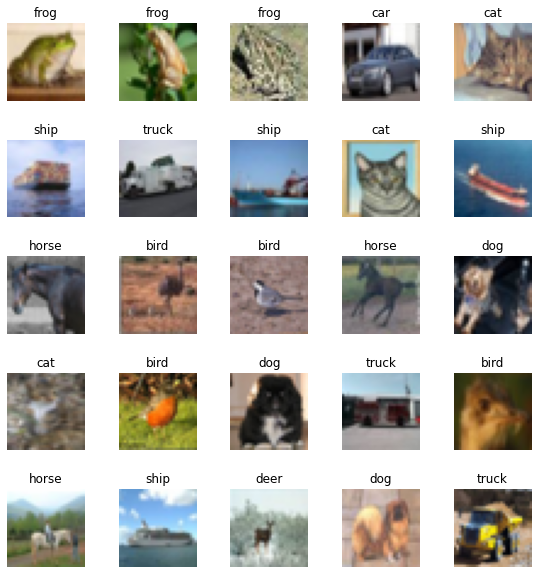

In [ ]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','car','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig, axs = plt.subplots(5,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(F))
    image = F[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(class_names[L[index][0]])

## preprocessing

In [ ]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

F = np.float32(F)
F = (F / 255 - 0.5) * 2
F = np.clip(F, -1, 1)

## generator

In [ ]:
# latent space dimension
z = Input(shape=(100,))

# classes
labels = Input(shape=(10,))

# Generator network
merged_layer = Concatenate()([z, labels])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, labels], outputs=generator, name='generator')

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         227328      concatenate_1[0][0]      

## discriminator

In [ ]:
# input image
img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

In [ ]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
______________________________________________________________________________________

In [ ]:
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## Adversial

In [ ]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [ ]:
d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]        

## visualization seed

In [ ]:
samples = 100
latent_dim = 100
noise_seed = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
condition_seed = to_categorical((np.arange(0, samples).reshape(-1, 1))%10, num_classes=10)

## generate grid image

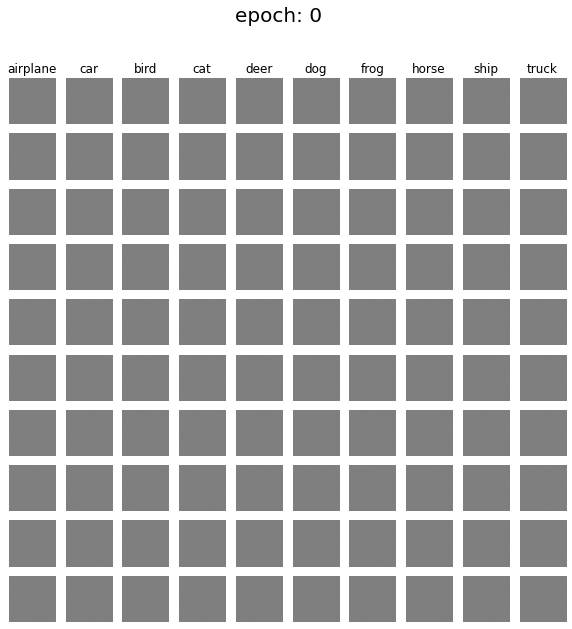

In [ ]:
def generate_images(epoch):
#   samples = 100
#   latent_dim = 100
#   noise_seed = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
#   condition_seed = to_categorical((np.arange(0, samples).reshape(-1, 1))%10, num_classes=10)

  x_fake = generator.predict([noise_seed, condition_seed])
  x_fake = np.clip(x_fake, -1, 1)
  x_fake = (x_fake + 1) * 127
  x_fake = np.round(x_fake).astype('uint8')

  fig = plt.figure(figsize=(10,10))

  for i in range(x_fake.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(x_fake[i, :, :, :])
      plt.axis('off')
      if i < 10:
          plt.title(class_names[i])

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  fig.suptitle(f'epoch: {epoch}', fontsize=20)
  plt.show()

generate_images(0)

In [ ]:
 history = {'gen_loss':[], 'disc_loss':[]}

In [ ]:
epochs = 30
batch_size = 64
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

for e in range(epochs):
    count = 0
    print(f'epoch: {e+1}/{epochs}')
    # init progbar for each epoch
    progbar = Progbar(target=len(X_train) // batch_size)
    for i in range(len(X_train) // batch_size):
        count += 1
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        # update brogba
        progbar.update(count, [('dics_loss', d_loss_batch), ('gen_loss', d_g_loss_batch[0])])
        history['gen_loss'].append(d_g_loss_batch)
        history['disc_loss'].append(d_loss_batch)
   
        # print(
        #     'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
        #     100*' ',
        #     end='\r'
        # )
    
    # d_loss.append(d_loss_batch)
    # d_g_loss.append(d_g_loss_batch[0])
    # print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        generate_images(e+1)
        # samples = 10
        # z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        # labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        # x_fake = generator.predict([z, labels])
        # x_fake = np.clip(x_fake, -1, 1)
        # x_fake = (x_fake + 1) * 127
        # x_fake = np.round(x_fake).astype('uint8')

        # for k in range(samples):
        #     plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
        #     plt.imshow(x_fake[k])
        #     plt.title(class_names[k])

        # plt.tight_layout()
        # plt.show()

Output hidden; open in https://colab.research.google.com to view.

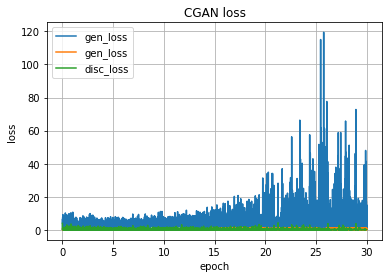

In [ ]:
x = np.linspace(0, epochs, len(history['gen_loss']))
plt.plot(x, history['gen_loss'], label='gen_loss')
plt.plot(x, history['disc_loss'], label='disc_loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('CGAN loss')
plt.legend()

In [ ]:
epochs = 30
batch_size = 64
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

for e in range(epochs):
    count = 0
    print(f'epoch: {e+1}/{epochs}')
    # init progbar for each epoch
    progbar = Progbar(target=len(X_train) // batch_size)
    for i in range(len(X_train) // batch_size):
        count += 1
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        # update brogba
        progbar.update(count, [('dics_loss', d_loss_batch), ('gen_loss', d_g_loss_batch[0])])
        history['gen_loss'].append(d_g_loss_batch)
        history['disc_loss'].append(d_loss_batch)
   
        # print(
        #     'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
        #     100*' ',
        #     end='\r'
        # )
    
    # d_loss.append(d_loss_batch)
    # d_g_loss.append(d_g_loss_batch[0])
    # print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        generate_images(e+31)
        # samples = 10
        # z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        # labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        # x_fake = generator.predict([z, labels])
        # x_fake = np.clip(x_fake, -1, 1)
        # x_fake = (x_fake + 1) * 127
        # x_fake = np.round(x_fake).astype('uint8')

        # for k in range(samples):
        #     plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
        #     plt.imshow(x_fake[k])
        #     plt.title(class_names[k])

        # plt.tight_layout()
        # plt.show()

Output hidden; open in https://colab.research.google.com to view.

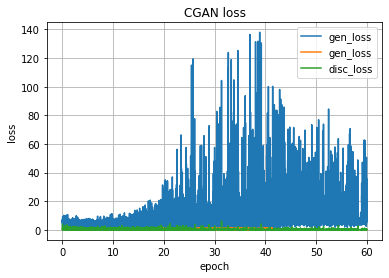

In [ ]:
x = np.linspace(0, 60, len(history['gen_loss']))
plt.plot(x, history['gen_loss'], label='gen_loss')
plt.plot(x, history['disc_loss'], label='disc_loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('CGAN loss')
plt.legend()

In [ ]:
import PIL
import imageio
import glob

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>